In [87]:
from collections import Counter
import math
import re

import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib.ticker import MaxNLocator
import matplotlib.lines as mlines

In [88]:
import json

with open("data/neuroimaging_landscape_survey.json") as q:
    questions = json.load(q)
    

In [89]:
q_name_option_mapping = {}
relevent_qs = questions['template']['steps']['xym8f2fbv6']['template']['widgets']
for q in relevent_qs.keys():
    try:
        q_name_option_mapping[relevent_qs[q]['template']['label']['logic']['value']] = [o['label']['logic']['value'] for o in relevent_qs[q]['template']['options']['staticOptions']]
    except KeyError:
        print(f"Question {q} has no options")
# q_name = questions['template']['steps']['xym8f2fbv6']['template']['widgets']['1Buytrx4WMw5WXF2oZcCcF']['template']['label']['logic']['value']
# q_options = [q['label']['logic']['value'] for q in questions['template']['steps']['xym8f2fbv6']['template']['widgets']['1Buytrx4WMw5WXF2oZcCcF']['template']['options']['staticOptions']]

Question fzk2D7C2Mv9YUg5WjB5Y4D has no options
Question gRUU3v2Bkb3LV8G8nvzSxs has no options
Question ig1Vm19EaCRbzML2969dRH has no options


In [90]:
# Remove HTML tags from the keys
cleaned_q_name_option_mapping = {re.sub(r'<.*?>', '', key): value for key, value in q_name_option_mapping.items()}

print(cleaned_q_name_option_mapping)

{'How many slices do the CT machine(s) collect?': ['less than 64 slices', '65 - 256 slices', 'greater than 256 slices', "I don't know"], 'What is the magnetic strength of the MRI machine(s)?': ['less than or equal to 1.5 Tesla', '1.6 - 3.0 Tesla', '3.1 - 7.0 Tesla', 'greater than 7.0 Tesla', "I don't know"], 'With whom do you typically share data? (Check all that apply)': ['within my lab/team', 'within my institution', 'Project collaborators at different institutions', 'within my state/province/region', 'within my country', 'From other countries within my continent', 'From other countries outside my continent', 'I don’t share data'], 'How do you deidentify your data? (Check all that apply)': ['Using generic identifiers for your patients/participants', 'Defacing', 'Intersubject Averaging (group level results)', 'None'], 'What types of neuroimaging data do you collect? (Check all that apply)': ['NIRS (Near-Infrared Spectroscopy)', 'sEEG (Stereoelectroencephalography)', 'EGoG (Electrocort

In [91]:
bar_graph_questions = [
    "Is the institution public or private?",
    "What types of neuroimaging data do you collect? (Check all that apply)",
    "What type(s) of detectors do your PET machines have?",
    "What is the magnetic strength of the MRI machine(s)?",
    "How many slices do the CT machine(s) collect?",
    "What are the top 3 challenges you have encountered generating data? (Can select fewer than 3)",
    "How large are the data you work with/generate?",
    "How do you typically store your data? (Check all that apply)",
    "If you do not use cloud storage, what are the main barrier(s)?",
    "What file formats do you use? (Check all that apply)",
    "Which of the following community (meta)data models do you use? (Check all that apply)",
    "How do you deidentify your data? (Check all that apply)",
    "What are the barriers to processing your data? (Check all that apply)",
    "With whom do you typically share data? (Check all that apply)",
    "From whom do you typically request data? (Check all that apply)",
    "How frequently do you share data?",
    "How frequently do you access shared data?",
    "What are the top 3 challenges you have encountered while sharing data? (Can select fewer than 3)",
    "What are the top 3 challenges you have encountered to access data? (Can select fewer than 3)",
    "Have you used any of the following databases for sharing data? Select \"Other\" for an institutional database. (check all that apply)",
    "Have you used any of the following databases for reusing shared data? Select \"Other\" for an institutional database. (check all that apply)",
    "When did you last share data through a database?",
    "When did you last use data from a database?",
]

In [92]:
# Read the CSV file using pandas
df = pd.read_csv("data/country_continent.csv")

# Convert the DataFrame to a dictionary
country_to_continent = df.set_index('country')['continent'].to_dict()


In [93]:
# Function to extract and clean categories from a string
def extract_and_clean_categories(text):
    # Remove text within parentheses
    text = re.sub(r'\s*\(.*?\)', '', text)
    # Remove brackets and split by ','
    text = text.strip('[]')
    categories = [cat.strip() for cat in text.split(',')]
    return categories

# Function to insert a newline if the label is longer than 30 characters
def insert_newline(label, max_length=30):
    if len(label) > max_length:
        # Find the position of the nearest space after the max_length
        split_pos = label.find(' ', max_length)
        if split_pos != -1:
            return label[:split_pos] + '\n' + label[split_pos+1:]
    return label


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from matplotlib.ticker import MaxNLocator
import matplotlib.lines as mlines

def plot_categorical_by_continent(
    survey, question, category_name, exclude_categories=set(),
    top_plot_separation=0.9, bottom_plot_squeeze=0.05, x_label_rotation=55,
    all_categories=set()):

    if not all_categories:
        for row in survey[question].dropna():
            categories = extract_and_clean_categories(row)
            categories = [cat for cat in categories if cat not in exclude_categories]
            all_categories.update(categories)
        all_categories = sorted(all_categories)
    
    
    formatted_category_map = {cat: insert_newline(cat) for cat in all_categories}
    formatted_categories = list(formatted_category_map.values())

    continents = survey['Continent'].unique()

    total_subplots = len(continents)
    rows = (total_subplots + 2) // 3
    fig, axes = plt.subplots(rows + 1, 3, figsize=(16, 4 * (rows + 1)), sharey=True)

    overall_ax = plt.subplot2grid((rows + 1, 3), (0, 0), colspan=3)
    
    overall_counter = Counter()
    for row in survey[question].dropna():
        categories = extract_and_clean_categories(row)
        categories = [cat for cat in categories if cat not in exclude_categories]
        overall_counter.update(categories)

    overall_count_df = pd.DataFrame(overall_counter.items(), columns=[category_name, 'Count'])
    overall_count_df[category_name] = overall_count_df[category_name].map(formatted_category_map)
    overall_count_df = overall_count_df.set_index(category_name).reindex(formatted_categories, fill_value=0).reset_index()

    overall_count_df = overall_count_df[overall_count_df['Count'] != 0]

    # Use the colorblind palette
    palette = sns.color_palette("colorblind", len(formatted_categories))

    sns.barplot(hue=category_name, x=category_name, y='Count', data=overall_count_df, palette=palette, ax=overall_ax)
    overall_ax.set_ylabel('Count')
    overall_ax.set_title(f'{category_name}', fontsize=14, fontweight='bold')
    overall_ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    overall_ax.set_xticks(range(len(formatted_categories)))
    overall_ax.set_xticklabels(formatted_categories, rotation=x_label_rotation, fontweight='bold')
    overall_ax.set_xlabel("")
    overall_ax.yaxis.set_tick_params(which='both', length=0)

    legend_handles = [mlines.Line2D([0], [0], color=palette[i], lw=2, label=cat) 
                    for i, cat in enumerate(formatted_categories)]
    overall_ax.legend(handles=legend_handles, title=category_name, loc='upper right', fontsize='small')

    row_index = 1
    for i, continent in enumerate(continents):
        if i % 3 == 0 and i > 0:
            row_index += 1
        ax = axes[row_index, i % 3]

        continent_data = survey[survey['Continent'] == continent]
        counter = Counter()
        for row in continent_data[question].dropna():
            categories = extract_and_clean_categories(row)
            categories = [cat for cat in categories if cat not in exclude_categories]
            counter.update(categories)

        count_df = pd.DataFrame(counter.items(), columns=[category_name, 'Count'])
        count_df[category_name] = count_df[category_name].map(formatted_category_map)
        count_df = count_df.set_index(category_name).reindex(formatted_categories, fill_value=0).reset_index()


        sns.barplot(hue=category_name, x=category_name, y='Count', data=count_df, palette='colorblind', ax=ax)
        ax.set_ylabel('Count')
        ax.set_title(f'{continent}', fontsize=14, fontweight='bold')
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.set_xticks(range(len(formatted_categories)))
        ax.set_xticklabels([])
        ax.set_xlabel("")

    # Adjust space between the overall graph and the continent-specific graphs
    plt.subplots_adjust(hspace=top_plot_separation)  # Larger space between the first and second rows

    # Manually reduce the space between continent-specific graphs
    for ax_row in axes[2:]:  # This targets the rows after the second one
        for ax in ax_row:
            box = ax.get_position()
            ax.set_position([box.x0, box.y0 + bottom_plot_squeeze, box.width, box.height])  # Move up by 0.05

    plt.savefig(f"{category_name.replace(' ', '_')}.png", bbox_inches='tight')
    plt.show()


In [94]:
replace_columns = {
    'Which country do you currently work in?': 'Which country do you reside?',
    'What is your academic/career stage?': 'What is your primary role?',
}

replace_values = {
    "0-8 years Early (e.g. grad student, postdoc, intern)": "Graduate Student",
    "9-15 years Mid (e.g. manager, assistant professor, associate professor)": "Faculty",
    "lack of funding": "Lack of funding",
    'Funds, time': "Lack of funding, time",
    "Funds": "Lack of funding",
    "Missing interoperability between standards and technology (e.g., scanner dependent pulse sequence protocols),not enough funding'": "Missing interoperability between standards and technology (e.g., scanner dependent pulse sequence protocols), Lack of funding",   
}

In [95]:
globe_survey = pd.read_csv('data/2024_09_12_survey.csv')
idor_survey = pd.read_csv('data/2024_09_12_idor1_survey.csv')

idor_survey.replace(replace_values, inplace=True)
idor_survey.rename(columns=replace_columns, inplace=True)



survey = pd.concat([globe_survey, idor_survey])


survey['Which country do you reside?'].replace({"Gambia, The": "Gambia"}, inplace=True)
survey['What is your primary role?'].replace({"Medical Radiographer ": "Technician", "Founder": "Other"}, inplace=True)
survey.replace(replace_values, inplace=True)

Continent counts:
       Continent  Count
0  North America     33
1         Africa     24
2         Europe     16
3  South America      7
4           Asia      4
5        Oceania      3


/tmp/ipykernel_888133/2234043718.py:14: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


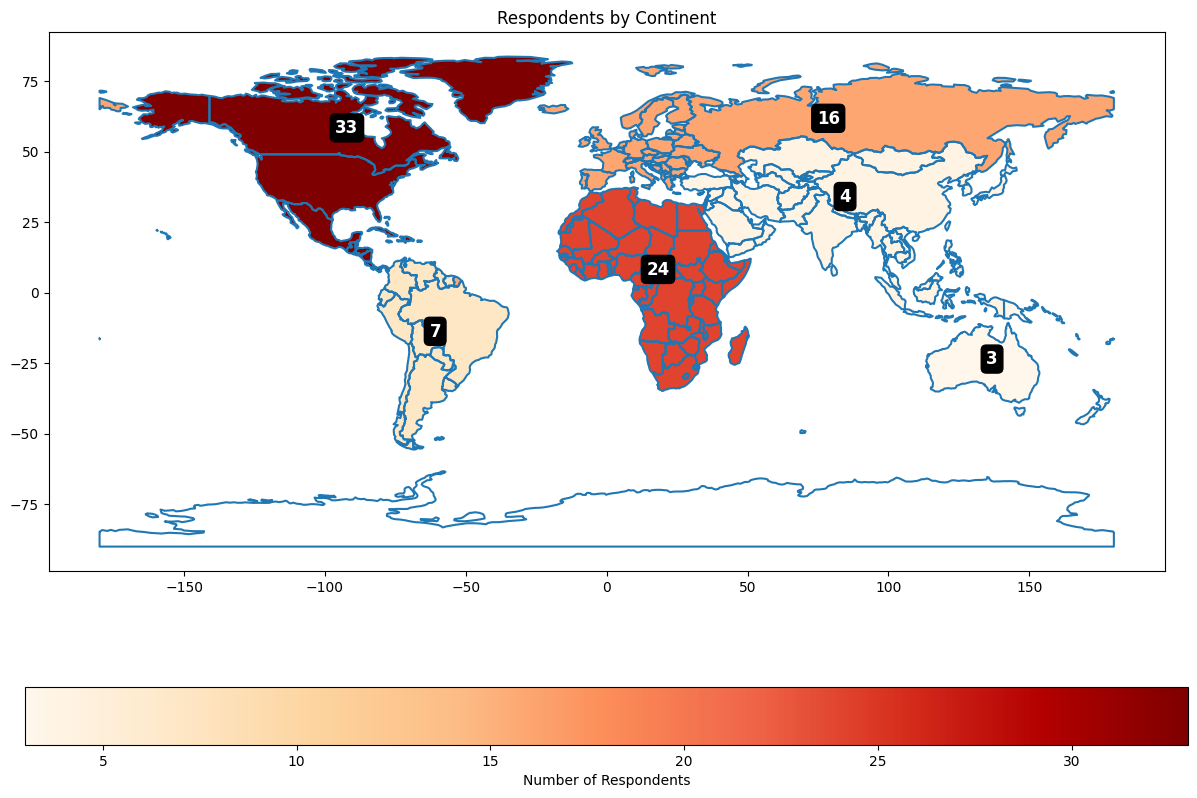

In [96]:
# Question 1: Which country do you reside?

survey['Continent'] = survey['Which country do you reside?'].map(country_to_continent)

# Count the number of respondents per continent
continent_counts = survey['Continent'].value_counts().reset_index()
continent_counts.columns = ['Continent', 'Count']

# Display the continent counts
print("Continent counts:")
print(continent_counts)

# Load the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


# Aggregate the counts per continent
continent_counts_dict = continent_counts.set_index('Continent').to_dict()['Count']

# Assign counts to the continents in the world map
world['Count'] = world['continent'].map(continent_counts_dict)

# Plot the map with a heatmap effect
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax)
world.plot(column='Count', ax=ax, legend=True, cmap='OrRd', legend_kwds={'label': "Number of Respondents", 'orientation': "horizontal"})

# Add labels for the counts
for continent, count in continent_counts_dict.items():
    # Calculate the centroid of the continent for the label position
    continent_geom = world[world['continent'] == continent].geometry.unary_union
    centroid = continent_geom.centroid
    plt.text(x=centroid.x, y=centroid.y, s=f"{count}", horizontalalignment='center', fontsize=12, fontweight='bold',
             color='white', bbox=dict(facecolor='black', edgecolor='black', boxstyle='round,pad=0.3'))


plt.title('Respondents by Continent')
plt.savefig("location.png", bbox_inches='tight')
plt.show()

/tmp/ipykernel_888133/2444497687.py:49: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  overall_ax = plt.subplot2grid((rows + 1, 3), (0, 0), colspan=3)


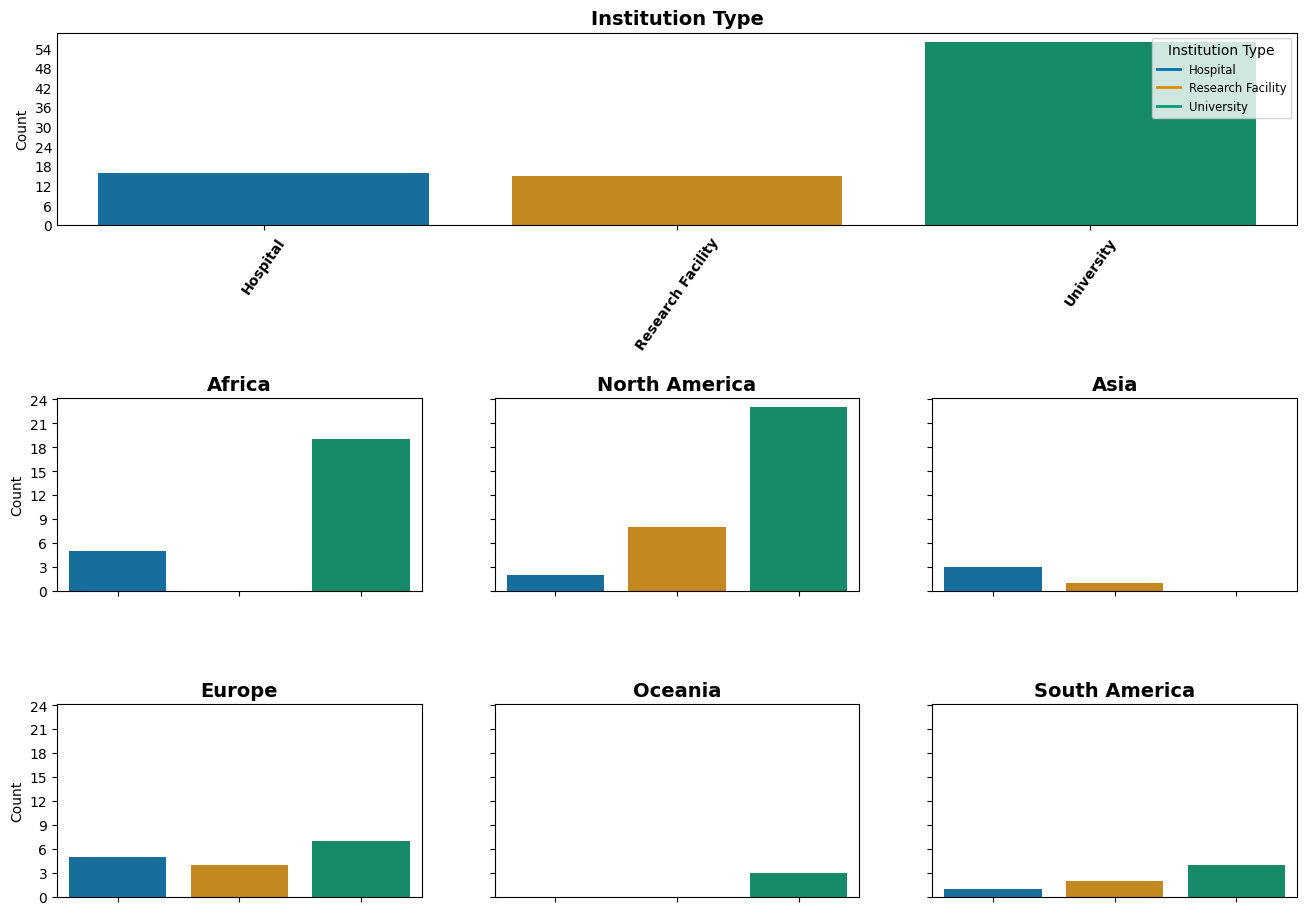

In [97]:
# Question 2: What type of institution are you employed

survey["What type of institution are you employed?"].replace({"UNIVERSITY HOSPITAL": "University", "Startups": "Research Facility"}, inplace=True)
plot_categorical_by_continent(
    survey,
    "What type of institution are you employed?",
    "Institution Type",
)

/tmp/ipykernel_888133/2444497687.py:49: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  overall_ax = plt.subplot2grid((rows + 1, 3), (0, 0), colspan=3)


ValueError: cannot reindex on an axis with duplicate labels

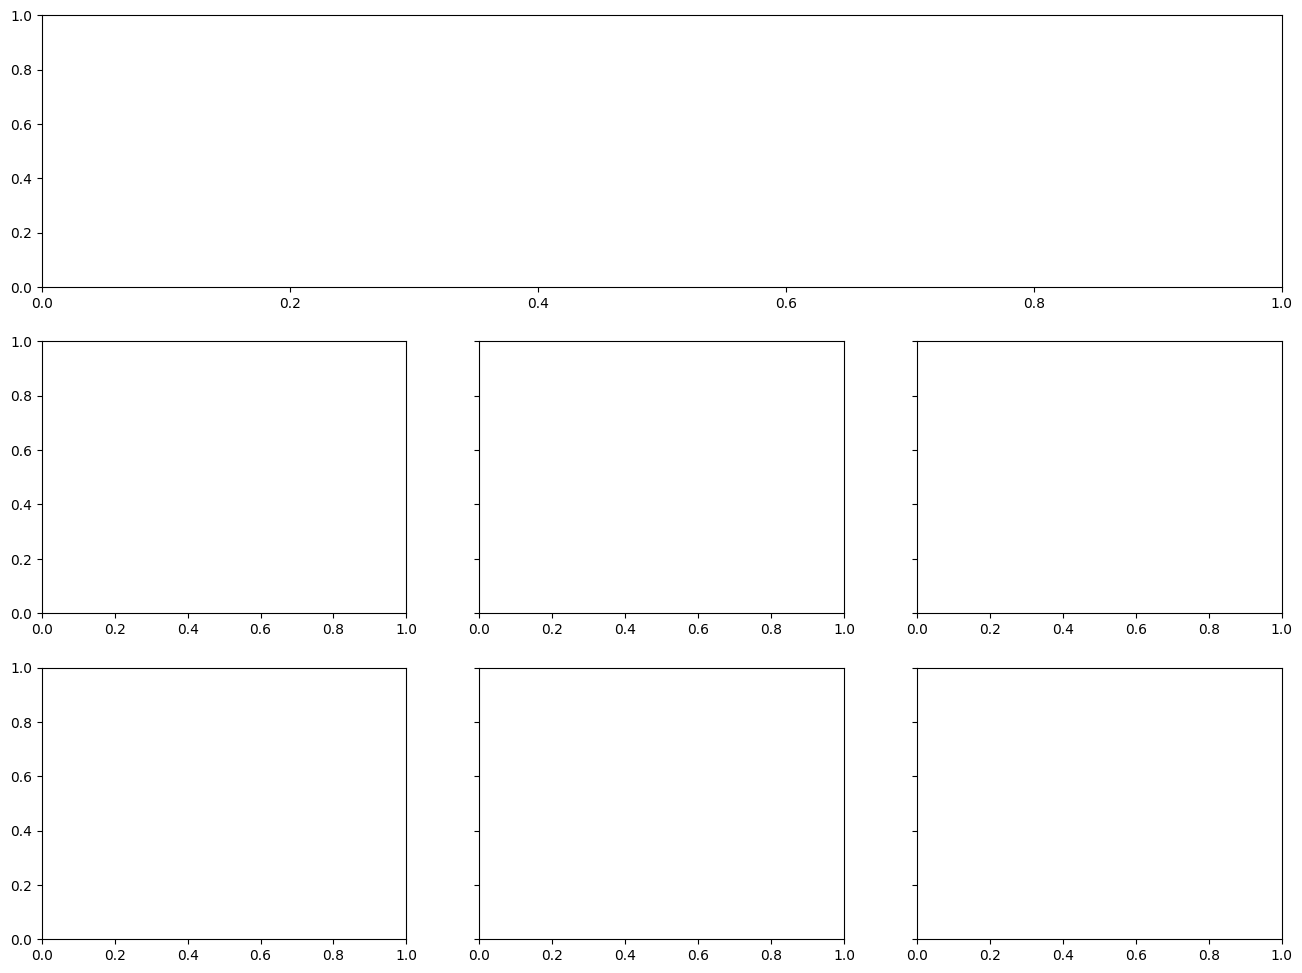

In [98]:
# Question 3: Is the institution public or private?

survey["Is the institution public or private?"].replace({"both public and private ": "Public"}, inplace=True)
plot_categorical_by_continent(
    survey,
    "Is the institution public or private?",
    "Institution: Public or Private",
)

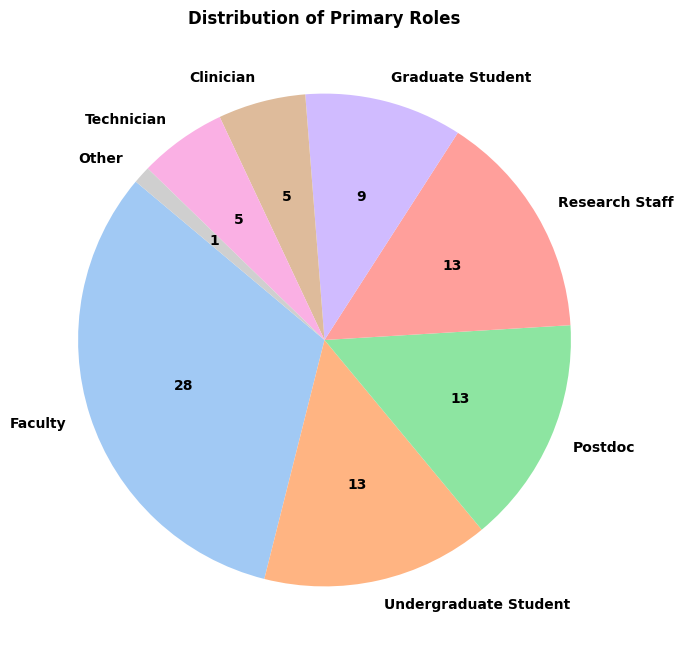

In [12]:
# Question 4: What is your primary role?
survey['What is your primary role?'].replace({"Medical Radiographer ": "Technician", "Founder": "Other"}, inplace=True)
role_counts = survey['What is your primary role?'].value_counts()
# Define a function to format the labels with the raw count
def func(pct, allvalues):
    absolute = pct / 100. * sum(allvalues)
    if absolute < 1:
        absolute = math.ceil(absolute)  # Ensure no values round down to 0
    else:
        absolute = round(absolute)
    return f'{absolute}'

# Plot pie chart
plt.figure(figsize=(10, 8))
plt.pie(role_counts, labels=role_counts.index, textprops={'fontweight': 'bold'}, autopct=lambda pct: func(pct, role_counts), startangle=140, colors=sns.color_palette('pastel'))
plt.title('Distribution of Primary Roles', fontweight="bold")
plt.savefig("roles.png", bbox_inches='tight')
plt.show()

/tmp/ipykernel_888133/875737579.py:46: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  overall_ax = plt.subplot2grid((rows + 1, 3), (0, 0), colspan=3)


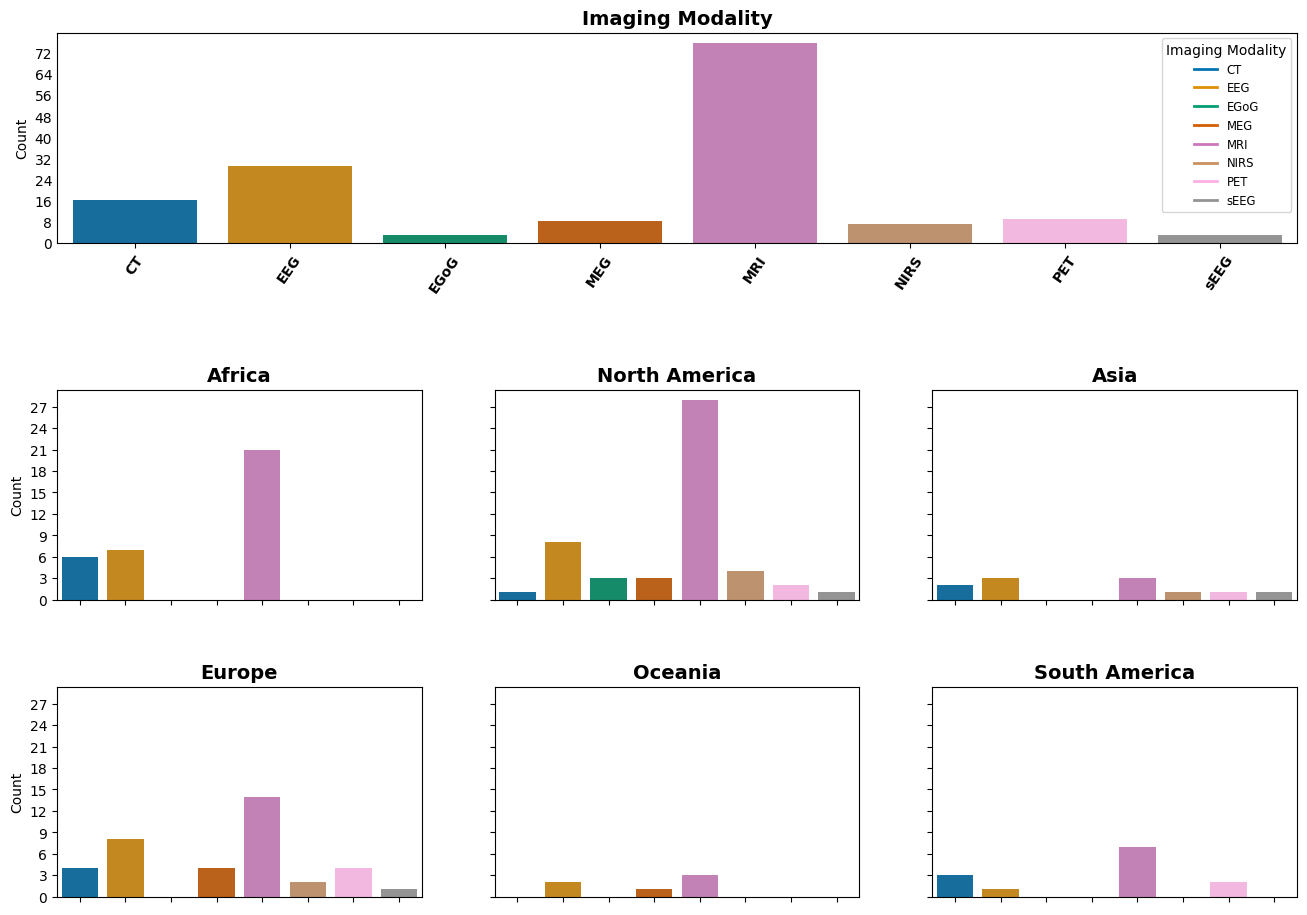

In [67]:
# Question 5: What types of neuroimaging data do you collect? (Check all that apply)

plot_categorical_by_continent(
    survey,
    "What types of neuroimaging data do you collect? (Check all that apply)",
    "Imaging Modality",
    {"Behavioral", "Synesthesia."},
    top_plot_separation=0.7,
)

In [73]:
cleaned_q_name_option_mapping["What type(s) of detectors do your PET machines have?"]

{'BGO crystal detector',
 'Digital LSO crystal detector',
 "I don't know",
 'LSO crystal detector'}

/tmp/ipykernel_888133/2444497687.py:49: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  overall_ax = plt.subplot2grid((rows + 1, 3), (0, 0), colspan=3)


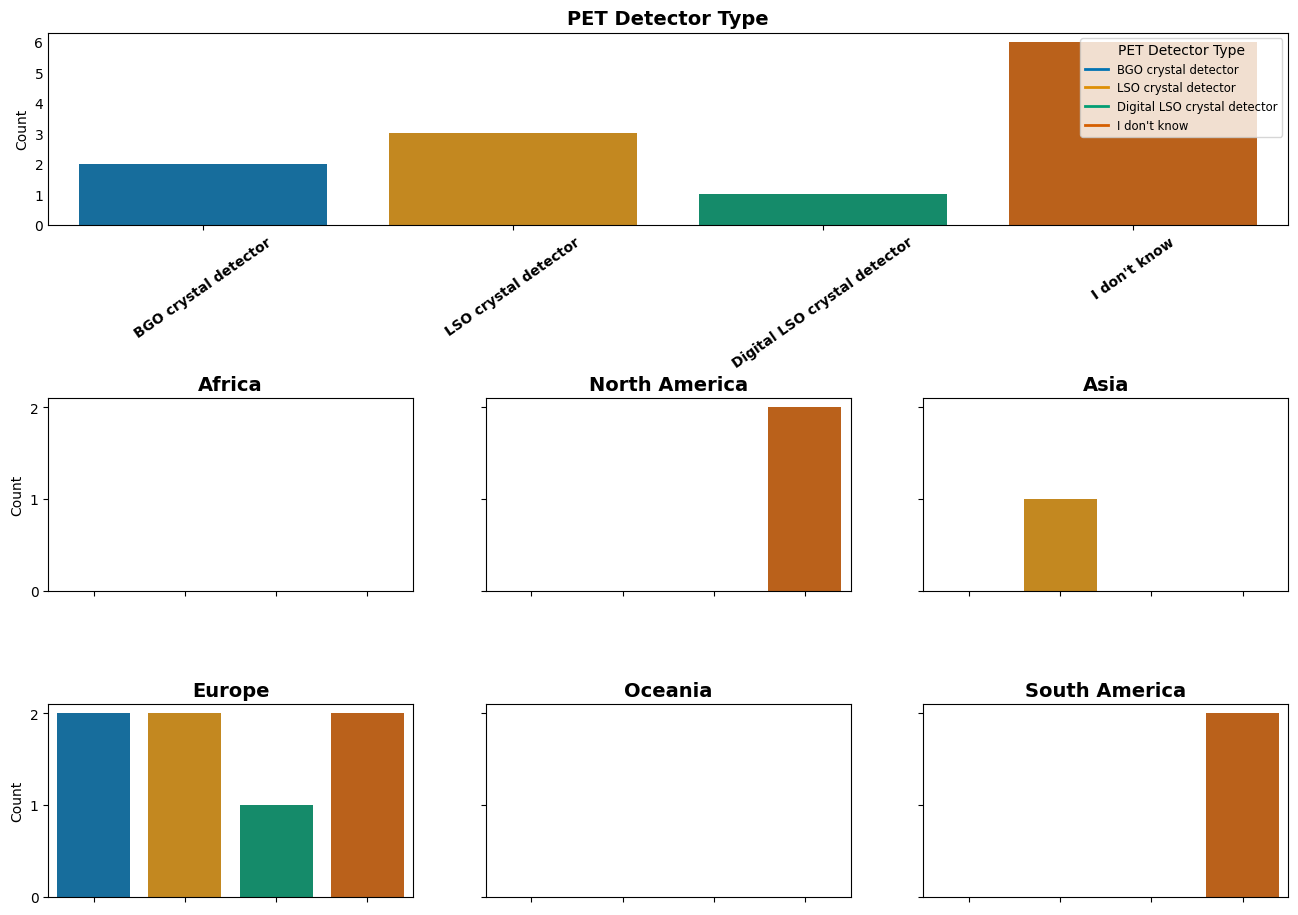

In [75]:
# Question 6: What type(s) of detectors do your PET machines have?

plot_categorical_by_continent(
    survey,
    "What type(s) of detectors do your PET machines have?",
    "PET Detector Type",
    x_label_rotation=35,
    all_categories=cleaned_q_name_option_mapping["What type(s) of detectors do your PET machines have?"]
)

In [104]:
survey["What is the magnetic strength of the MRI machine(s)?"] 

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
     ..
2   NaN
3   NaN
4   NaN
5   NaN
6   NaN
Name: What is the magnetic strength of the MRI machine(s)?, Length: 87, dtype: float64

In [103]:
# These are NaNs for some reason :(
survey["What is the magnetic strength of the MRI machine(s)?"].dropna(inplace=True)
survey["What is the magnetic strength of the MRI machine(s)?"] = survey["What is the magnetic strength of the MRI machine(s)?"].str.split(',')
q7_survey = survey.explode("What is the magnetic strength of the MRI machine(s)?")
q7_survey["What is the magnetic strength of the MRI machine(s)?"]


0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
     ..
2   NaN
3   NaN
4   NaN
5   NaN
6   NaN
Name: What is the magnetic strength of the MRI machine(s)?, Length: 87, dtype: float64

/tmp/ipykernel_888133/2444497687.py:49: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  overall_ax = plt.subplot2grid((rows + 1, 3), (0, 0), colspan=3)


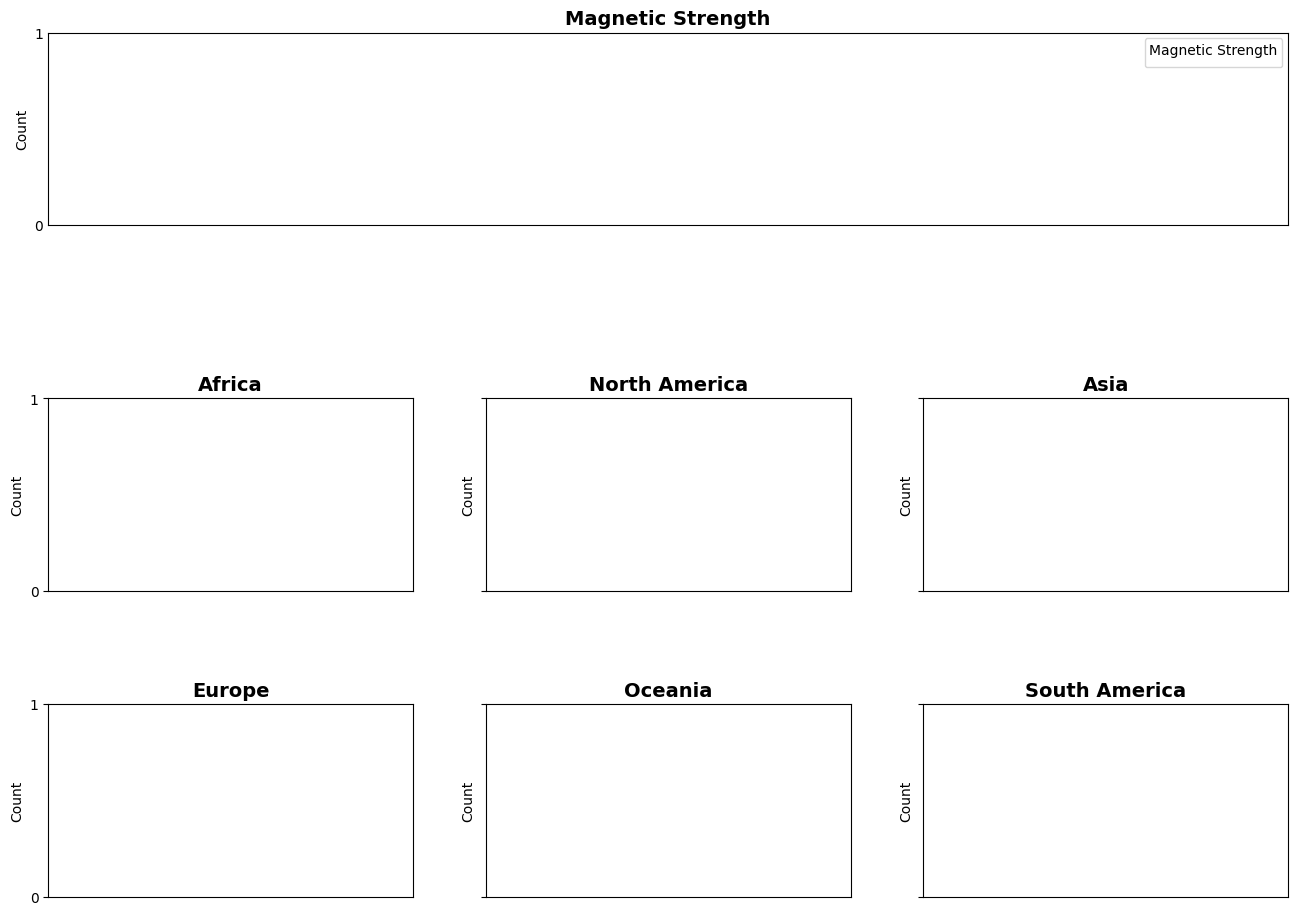

In [82]:
# Question 7: "What is the magnetic strength of the MRI machine(s)?"


q7_survey["What is the magnetic strength of the MRI machine(s)?"].replace({"1.5 - 3.0 Tesla": "1.6 - 3.0 Tesla"}, inplace=True)
plot_categorical_by_continent(
    q7_survey,
    "What is the magnetic strength of the MRI machine(s)?",
    "Magnetic Strength",
    all_categories=set(),
)

In [27]:
survey["What purpose(s) is the data being collected for?"]

0             Clinical
1             Clinical
2             Clinical
3             Research
4             Clinical
           ...        
2             Research
3    Clinical,Research
4             Research
5             Clinical
6             Clinical
Name: What purpose(s) is the data being collected for?, Length: 87, dtype: object

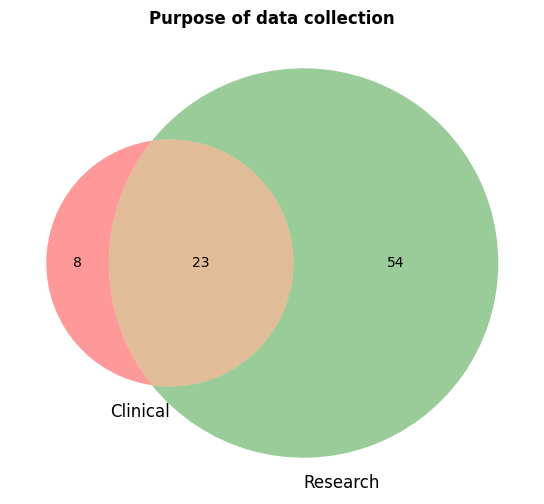

In [28]:

# Define sets for the Venn diagram
set_labels = ['Clinical', 'Research']
set_dict = {label: set() for label in set_labels}

# Populate sets based on categories
for index, category in survey.reset_index().iterrows():
    if pd.isna(category["What purpose(s) is the data being collected for?"]):
        continue
    categories = category["What purpose(s) is the data being collected for?"].split(',')
    if 'Clinical' in categories and 'Research' in categories:
        set_dict['Clinical'].add(index)
        set_dict['Research'].add(index)
    elif 'Clinical' in categories:
        set_dict['Clinical'].add(index)
    elif 'Research' in categories:
        set_dict['Research'].add(index)

# Plot Venn Diagram
plt.figure(figsize=(8, 6))
venn = venn2([set_dict['Clinical'], set_dict['Research']], 
             set_labels)
plt.title('Purpose of data collection', fontweight="bold")
plt.savefig('purpose.png', bbox_inches="tight")
plt.show()

In [43]:
survey["What are the top 3 challenges you have encountered generating data? (Can select fewer than 3)"] = survey["What are the top 3 challenges you have encountered generating data? (Can select fewer than 3)"].str.split(',')
q9_survey = survey.explode("What are the top 3 challenges you have encountered generating data? (Can select fewer than 3)")

In [45]:
q9_survey["What are the top 3 challenges you have encountered generating data? (Can select fewer than 3)"].unique()

array(['Lack of institutional infrastructure (ethernet',
       ' wireless connection)',
       'Lack of specialized personnel (people that generate protocols)',
       'Lack of national infrastructure (internet', ' electricity)',
       'Lack of high-end technology (computers/scanners/lack of storage)',
       nan,
       'Missing interoperability between standards and technology (e.g.',
       ' scanner dependent pulse sequence protocols)',
       'Lack of connection between neurologist',
       ' radiologist and neuroscientist ', 'None',
       'Lack of individuals with synesthesia.', 'not enough funding',
       'Lack of funding', ' time'], dtype=object)

/tmp/ipykernel_435753/3004758187.py:46: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  overall_ax = plt.subplot2grid((rows + 1, 3), (0, 0), colspan=3)
/tmp/ipykernel_435753/3004758187.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_name, y='Count', data=overall_count_df, palette='colorblind', ax=overall_ax)
/tmp/ipykernel_435753/3004758187.py:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_name, y='Count', data=count_df, palette='colorblind', ax=ax)


Plotting for Africa... on row 1, col 0
Plotting for North America... on row 1, col 1


/tmp/ipykernel_435753/3004758187.py:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_name, y='Count', data=count_df, palette='colorblind', ax=ax)


Plotting for Asia... on row 1, col 2
Plotting for Europe... on row 2, col 0


/tmp/ipykernel_435753/3004758187.py:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_name, y='Count', data=count_df, palette='colorblind', ax=ax)
/tmp/ipykernel_435753/3004758187.py:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_name, y='Count', data=count_df, palette='colorblind', ax=ax)


Plotting for Oceania... on row 2, col 1
Plotting for South America... on row 2, col 2


/tmp/ipykernel_435753/3004758187.py:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_name, y='Count', data=count_df, palette='colorblind', ax=ax)
/tmp/ipykernel_435753/3004758187.py:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_name, y='Count', data=count_df, palette='colorblind', ax=ax)


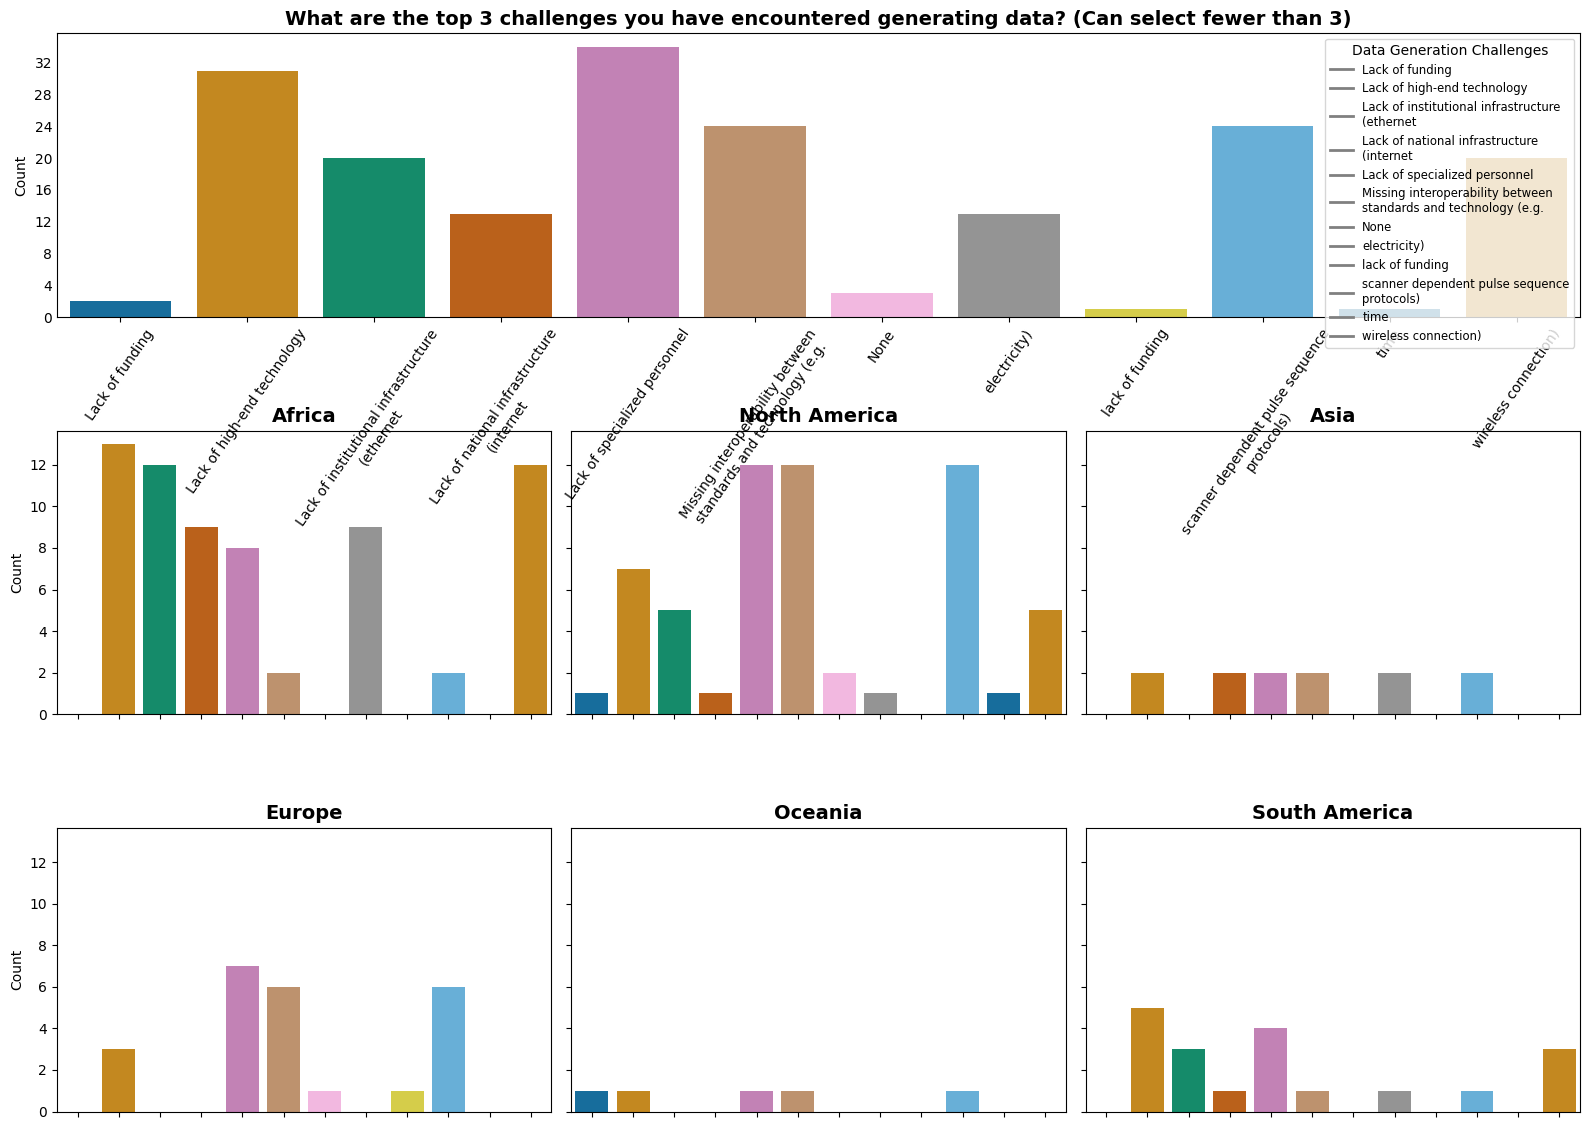

In [47]:
q9_survey["What are the top 3 challenges you have encountered generating data? (Can select fewer than 3)"].replace(
    {
        "Funds": "lack of funding",
        "not enough funding": "lack of funding",
        "time": "lack of funding",
        "Lack of individuals with synesthesia.": "None",
        "Lack of connection between neurologist": 'Lack of specialized personnel (people that generate protocols)',
        " radiologist and neuroscientist ": 'Lack of specialized personnel (people that generate protocols)',
    }, inplace=True)
plot_categorical_by_continent(
    q9_survey,
    "What are the top 3 challenges you have encountered generating data? (Can select fewer than 3)",
    "Data Generation Challenges",
)

/tmp/ipykernel_304359/2956101618.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_name, y='Count', data=count_df, palette='colorblind', ax=ax)
/tmp/ipykernel_304359/2956101618.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_name, y='Count', data=count_df, palette='colorblind', ax=ax)
/home/jdkent/projects/BRIDGESurvey/.bsurvey/lib/python3.8/site-packages/seaborn/categorical.py:379: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(-.5, n - .5, auto=None)
/tmp/ipykernel_304359/2956101618.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be rem

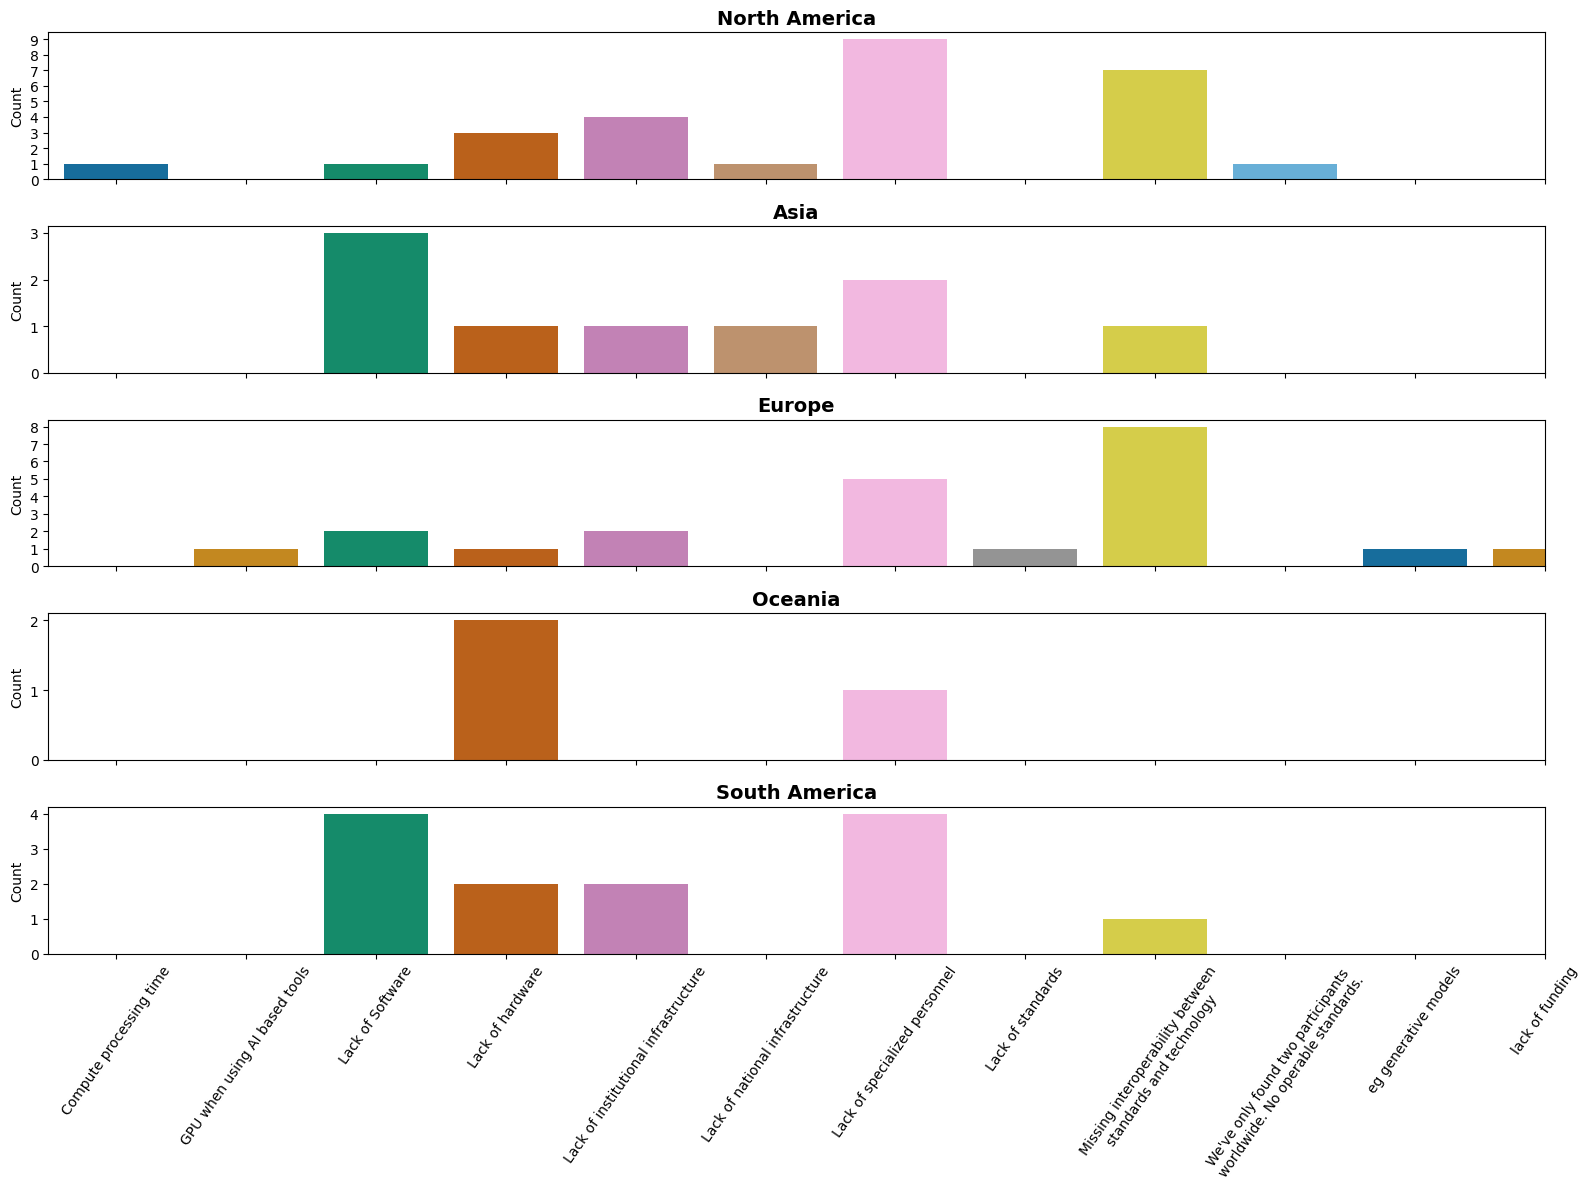

In [248]:
plot_categorical_by_continent(
    survey,
    "What are the barriers to processing your data? (Check all that apply)",
    "Data Processing Challenges",
)

/tmp/ipykernel_304359/2956101618.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_name, y='Count', data=count_df, palette='colorblind', ax=ax)
/tmp/ipykernel_304359/2956101618.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_name, y='Count', data=count_df, palette='colorblind', ax=ax)
/home/jdkent/projects/BRIDGESurvey/.bsurvey/lib/python3.8/site-packages/seaborn/categorical.py:379: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(-.5, n - .5, auto=None)
/tmp/ipykernel_304359/2956101618.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be rem

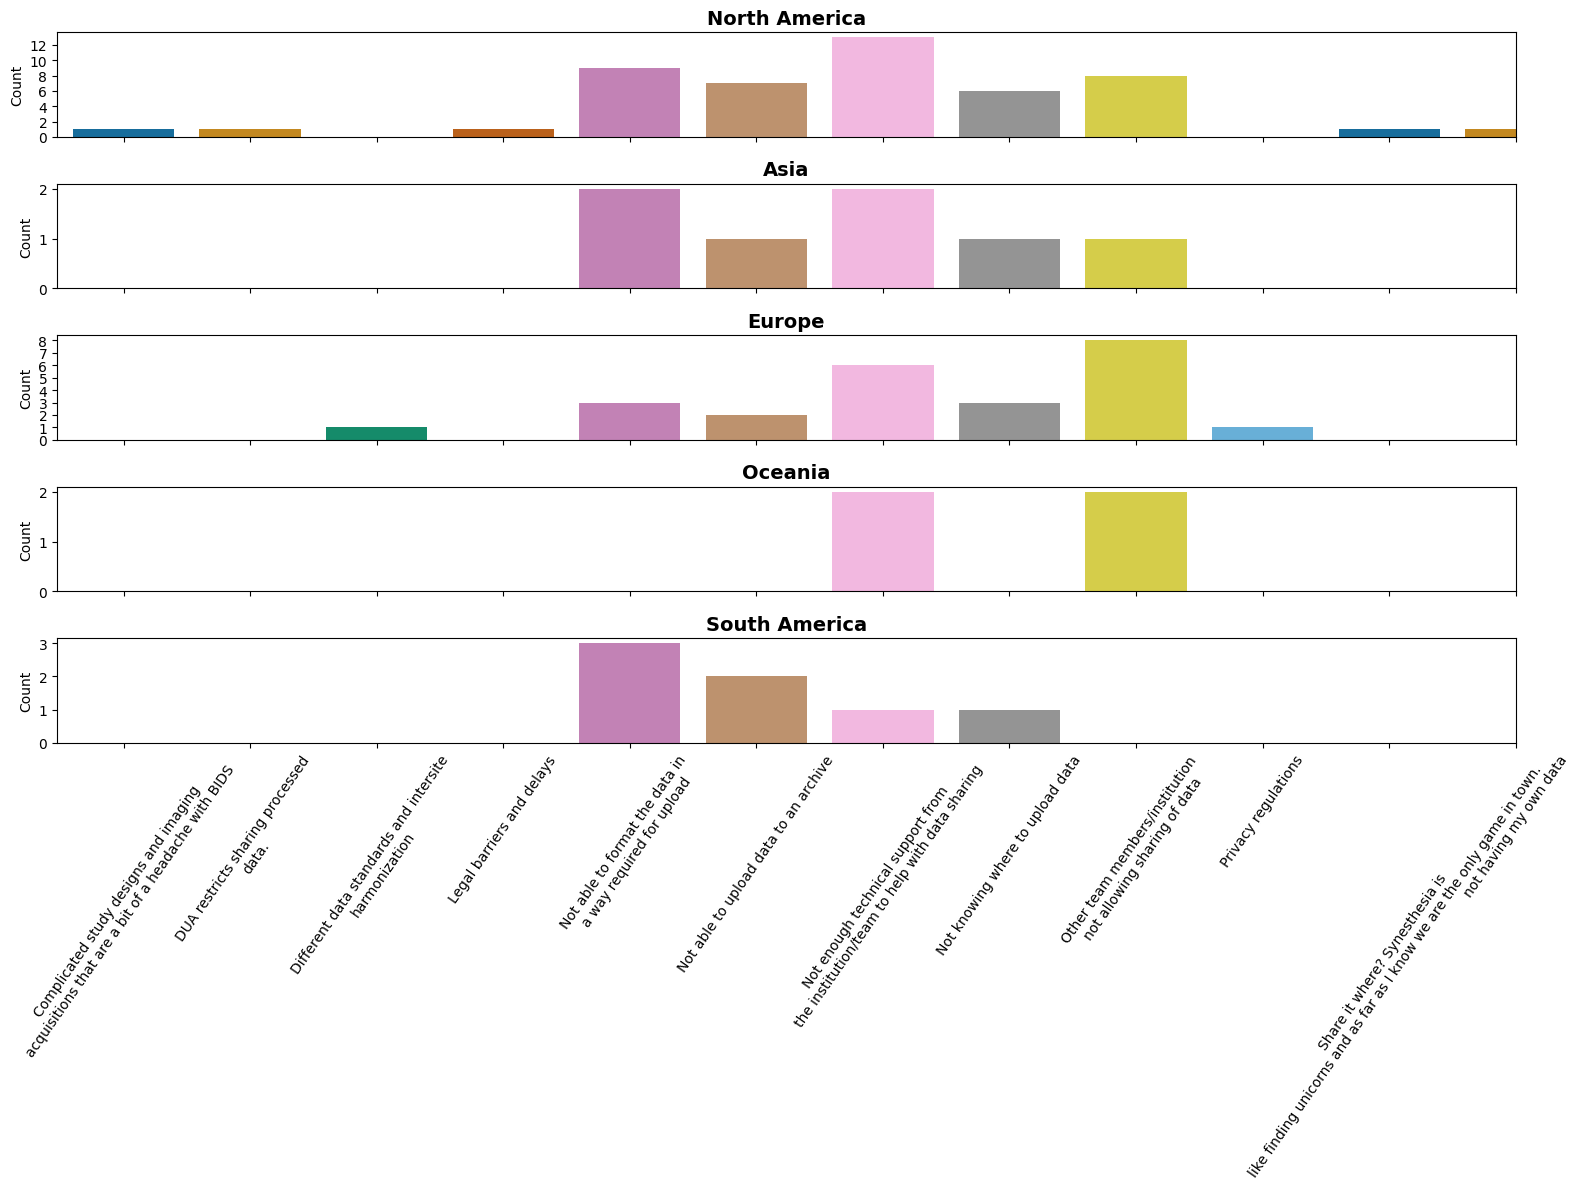

In [249]:
plot_categorical_by_continent(
    survey,
    "What are the top 3 challenges you have encountered while sharing data? (Can select fewer than 3)",
    "Data Sharing Challenges",
)

/tmp/ipykernel_304359/2956101618.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_name, y='Count', data=count_df, palette='colorblind', ax=ax)
/tmp/ipykernel_304359/2956101618.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_name, y='Count', data=count_df, palette='colorblind', ax=ax)
/home/jdkent/projects/BRIDGESurvey/.bsurvey/lib/python3.8/site-packages/seaborn/categorical.py:379: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(-.5, n - .5, auto=None)
/tmp/ipykernel_304359/2956101618.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be rem

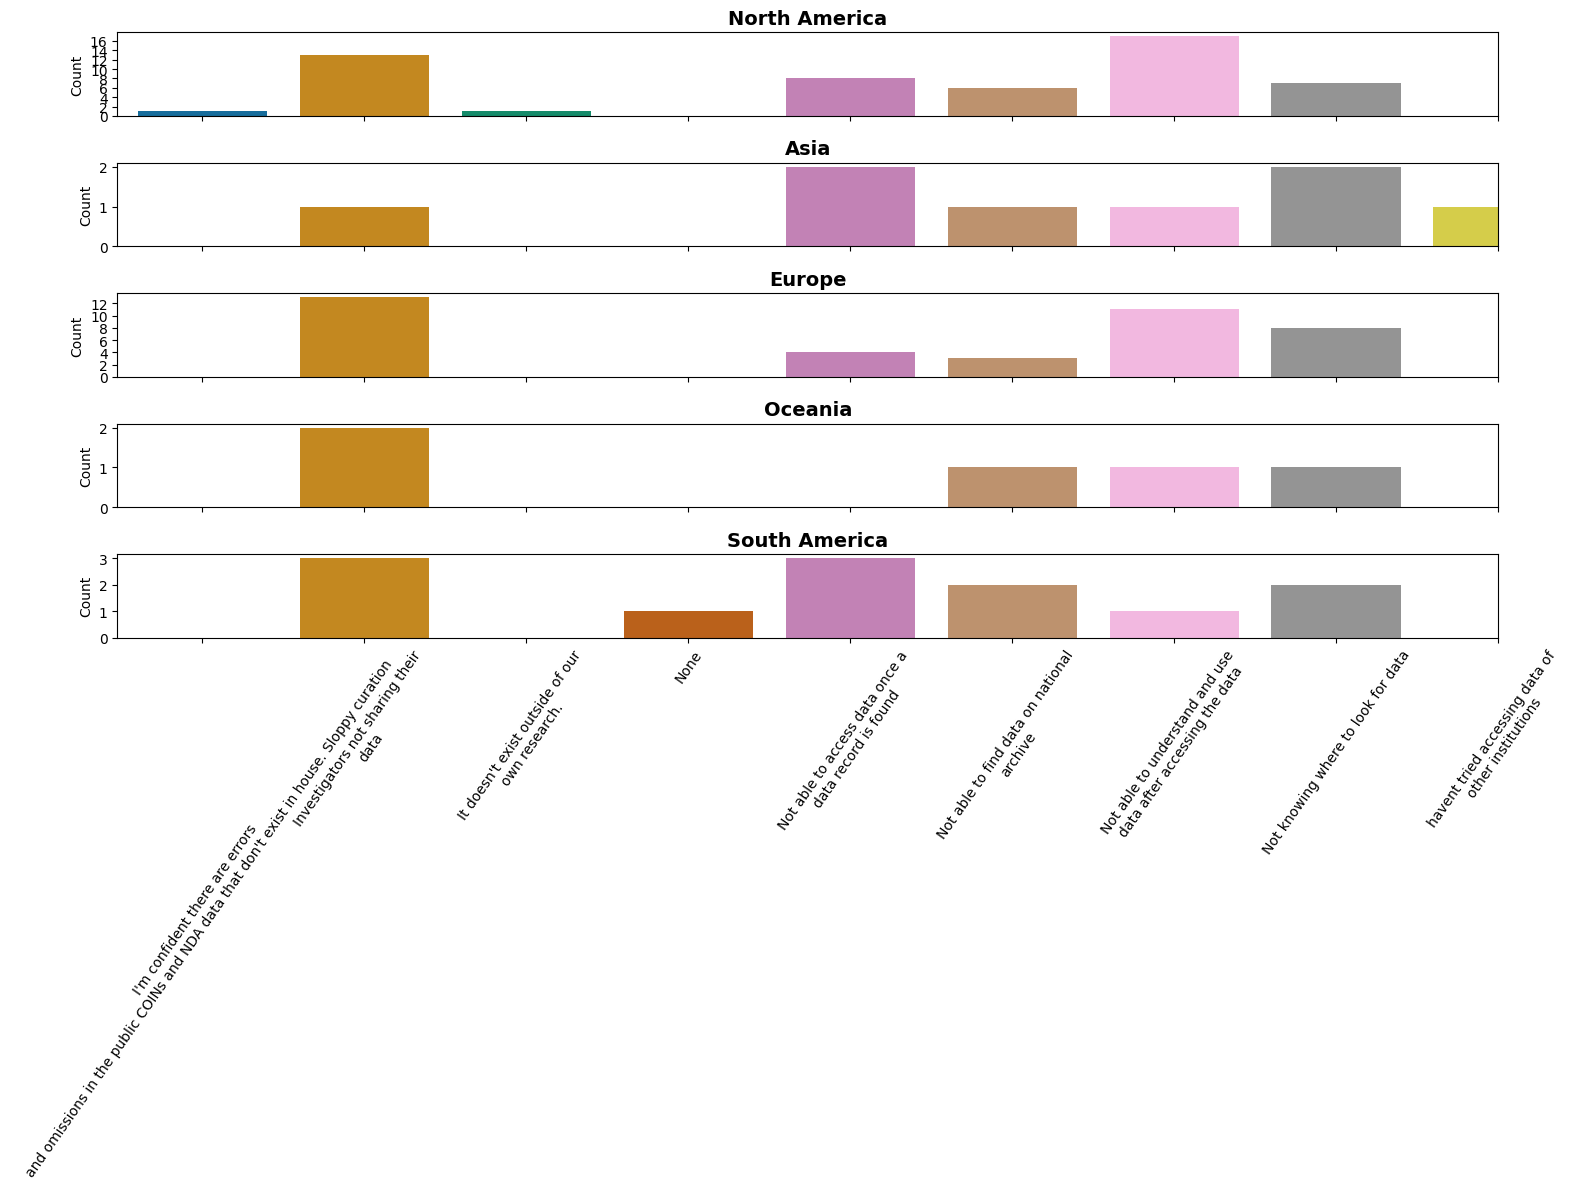

In [250]:
plot_categorical_by_continent(
    survey,
    "What are the top 3 challenges you have encountered to access data? (Can select fewer than 3)",
    "Data Access Challenges",
    {"I'm confident there are errors and omissions in the public COINs and NDA data that don't exist in house. Sloppy curation "},
)